# Ch14. 어텐션 메커니즘 (Attention Mechanism)

# v02. 텍스트 요약 (Text Summarization with Attention mechanism)

- 텍스트 요약은 상대적으로 큰 원문을 핵심 내용만 간추려서 상대적으로 작은 요약문으로 변환하는 것을 말한다.
- 읽는 사람이 시간을 단축해서 내용을 빠르게 이해할 수 있다는 점에서 글을 많이 쓰는 사람들에게는 꼭 필요한능력 중 하나일 것이다.
- 그런데 만약 기계가 이를 자동으로 해줄 수만 있다면 얼마나 좋을까?
- 이번 챕터에서는 그 중 한 가지 방법인 seq2seq를 구현해본다.
- 그리고 어텐션 메커니즘(attention mechanism)을 적용해보자.

> 이번 챕터는 시퀀스-투-시퀀스(Sequence-to-Sequence, seq2seq) 챕터를 선행하는 것이 좋다. (모델을 설계하는 코드가 거의 동일)

<br>

## 2.1 텍스트 요약 (Text Summarization)

- 텍스트 요약은 크게 다음 2가지로 나뉜다.
  1. 추출적 요약 (extractive summarization)
  2. 추상적 요약 (abstractive summarization)

<br>

### 2.1.1 추출적 요약 (extractive summarization)

- 추출적 요약은 원문에서 중요한 핵심 문장 또는 단어구를 몇 개 뽑아서 이들로 구성된 요약문을 만드는 방법이다.
- 그렇기 때문에 추출적 요약의 결과로 나온 요약문의 문장이나 단어구들은 전부 원문에 있는 문장들이다.
- 추출적 요약의 대표적인 알고리즘으로 머신 러닝 알고리즘인 **텍스트랭크(TextRank)**가 있다.
- [해당 링크](https://summariz3.herokuapp.com/)에서 텍스트랭크로 구현된 세 줄 요약기를 시험해볼 수 있다.

- 위 링크로 이동하여 인터넷 뉴스나 가지고 있는 글들을 복사 + 붙여넣기하여 결과를 확인해보자.
- 세 개의 문장은 전부 원문에 존재하던 문장들이다.
- 이 방법의 단점이라면, 이미 존재하는 문장이나 단어구로만 구성하므로 모델의 언어 표현 능력이 제한된다는 점이다.

- 그렇다면 마치 사람처럼 원문에 없던 단어나 문장을 사용하면서 핵심만 간추려서 표현하는 요약 방법은 없을까?

<br>

### 2.1.2 추상적 요약 (abstractive summarization)

- 추상적 요약은 원문에 없던 문장이라도 핵심 문맥을 반영한 새로운 문장을 생성해서 원문을 요약하는 방법이다.
- 마치 사람이 요약하는 것 같은 방식인데, 당연히 추출적 요약보다는 난이도가 높다.
- 이 방법은 주로 인공 신경망을 사용하며 대표적인 모델로 seq2seq가 있다.
- 이 방법의 단점이라면 seq2seq와 같은 인공 신경망들은 기본적으로 **지도 학습**이라는 점이다.
- 다시 말해 추상적 요약을 인공 신경망으로 훈련하기 위해서는 '원문' 뿐만 아니라 '실제 요약문'이라는 레이블 데이터가 있어야 한다.
- 그렇기 때문에 데이터를 구성하는 것 자체가 하나의 부담이다.
- 이번 챕터에서는 이미 공개된 데이터를 사용해서 추상적 요약을 실습해본다.

<br>

## 2.2 아마존 리뷰 데이터에 대한 이해

- 이번 챕터에서 사용할 데이터는 아마존 리뷰 데이터이다.
- 아래의 링크에서 데이터를 다운로드 한다.
- [https://www.kaggle.com/snap/amazon-fine-food-reviews](https://www.kaggle.com/snap/amazon-fine-food-reviews)

<br>

### 2.2.1 필요 패키지 불러오기

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

<br>

### 2.2.2 데이터 로드하기

- `Reviews.csv` 파일을 불러와 데이터프레임에 저장한다.
- 이 데이터는 실제로는 약 56만 개의 샘플을 가지고 있다.
- 하지만 여기서는 간단히 10만 개의 샘플만 사용한다.
- 이는 `pd.read_csv()`의 `nrows`의 인자로 10만이라는 숫자를 적어주면 된다.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/datasets/amazon-fine-food-reviews/Reviews.csv",
                   nrows=100000)
print("전체 리뷰 개수 : ", (len(data)))

전체 리뷰 개수 :  100000


<br>

- 5개의 샘플만 출력해보자.

In [4]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


<br>

### 2.2.3 필요한 데이터 분리

- 5개의 샘플을 출력해보면 `Id`, `ProductId`, `UserId`, `ProfileName`, `HelpfulnessNumerator`, `HelpfulnessDenominator`, `Score`, `Time`, `Summary`, `Text`이라는 10개의 열이 존재함을 알 수 있다.
- 그런데 사실 이 중 필요한 열은 `Text`열과 `Summary`열 뿐이다.

- `Text`열과 `Summary`열만을 분리하고, 다른 열들은 데이터에서 제외시켜서 재저장한다.
- 그리고 5개의 샘플을 출력한다.

In [5]:
data = data[['Text', 'Summary']]
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


<br>

- `Text`열이 원문이고, `Summary`열이 `Text`열에 대한 요약이다.
- 다시 말해 모델은 `Text`(원문)으로부터 `Summary`(요약)을 예측하도록 훈련된다.

- 랜덤으로 샘플 몇 가지를 더 출력해보자.

In [6]:
data.sample(10)

,Text,Summary
94199,I have 2 poodle mixes and they had soft poop l...,Great Product & No Dented Cans!
82025,I bought this to make a cornbread recipe. Coco...,HEAVENLY COCONUT FLOUR
44772,Best Almonds ever esp if you are trying to con...,Best Almonds ever esp if you are trying to con...
36701,I brought this last week and just opened one b...,Great Food for Diet Plan and Keep you stuffed!!
9004,I tried this flavor within a variety pack and ...,Island Escape!
62132,I have tried many different brands and types o...,My Favorite
89909,If you feel like your dog should be fed with c...,Gourmet dinner for your dog
5385,I have been using this spice mix for many year...,"A TASTE OF ""N'AW'INS"" GREAT SPICE MIX FOR MANY..."
51641,I used this to make cinnamon toothpicks and it...,"Great stuff, but be careful."
34974,"I ordered the product a few weeks ago, and the...","Product is below par, very hard to chew"


- 원문은 꽤 긴 반면에, `Summary`에는 3~4개의 단어만으로 구성된 경우도 많아 보인다.

<br>

### 2.2.4 데이터 정제하기

#### 2.2.4.1 중복 데이터 제거

- 데이터에 중복 샘플이 있는 지 확인해보자.

In [7]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


- 전체 데이터는 10만개의 샘플이 존재하지만, 실제로는 꽤 많은 원문이 중복되어 중복을 배제한 유일한 원문의 개수는 88,426개이다.
- 중복 샘플이 무려 약 1,200개나 있다는 의미이다.
- `Summary`는 중복이 더 많지만, 원문은 다르더라도 짧은 문장인 요약은 내용이 겹칠 수 있음을 가정하고 일단 중복 제거를 하지 않는다.
- `Summary`의 길이 분포는 뒤에서 확인한다.

In [ ]:
# Text 열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=["Text"], inplace=True)

In [9]:
print("전체 샘플수 : ", len(data))

전체 샘플수 :  88426


<br>

#### 2.2.4.2 결측값 제거

- 이제 Null 샘플이 존재하는 지 확인해보자.

In [10]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


- `Summary`에서 1개의 Null 샘플이 남아 있다.
- 이를 제거해준다.

In [11]:
# Null 값을 가진 샘플 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플 수 : ', len(data))

전체 샘플 수 :  88425


<br>

#### 2.2.4.3 단어 정규화 사전 생성

- 지금까지는 불필요한 샘플의 수를 줄이기 위한 정제 과정이였다.
- 이제 샘플 내부를 전처리해야 한다.
- 단어 정규화와 불용어 제거를 위해 각각의 참고 자료가 필요하다.
- 동일한 의미를 가졌지만 스펠링이 다른 단어들을 정규화하기 위한 사전을 만든다.
- 이 사전은 [해당 링크](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)를 참고하여 만들어진 사전이다.

In [ ]:
# 전처리 함수 내 사용
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", 
                "could've": "could have", "couldn't": "could not", "didn't": "did not", 
                "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", 
                "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", 
                "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have",
                "I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", 
                "i'll": "i will", "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", 
                "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                "mightn't": "might not","mightn't've": "might not have", "must've": "must have", 
                "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", 
                "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", 
                "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
                "she'll": "she will", "she'll've": "she will have", "she's": "she is", 
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", 
                "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", 
                "that'd've": "that would have", "that's": "that is", "there'd": "there would", 
                "there'd've": "there would have", "there's": "there is", "here's": "here is",
                "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", 
                "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
                "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                "what're": "what are", "what's": "what is", "what've": "what have", 
                "when's": "when is", "when've": "when have", "where'd": "where did", 
                "where's": "where is", "where've": "where have", "who'll": "who will", 
                "who'll've": "who will have", "who's": "who is", "who've": "who have", 
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", 
                "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", 
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                "you'll've": "you will have", "you're": "you are", "you've": "you have"}

<br>

#### 2.2.4.4 불용어 정의

- NLTK의 불용어를 저장하고 개수를 확인해보자.

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
# NLTK의 불용어
stop_words = set(stopwords.words('english'))
print('불용어 개수 : ', len(stop_words))

불용어 개수 :  179


In [ ]:
print(stop_words)

```
{'does', 'himself', 't', 'mightn', 'most', "mustn't", 'those', 'couldn', 'any', 'too', "wouldn't", 'having', 
... 중략 ...
'themselves', 'do', 'will', 'i', 'didn', 'our', 'or', 'we', 'than', 'for', 'by', 'doesn', 'out', 'off', 've'}
```

<br>

#### 2.2.4.5 전처리 함수 설계

In [ ]:
# 전처리 함수
def preprocess_sentence(sentence, remove_stopwords = True):

    # 텍스트 소문자화
    sentence = sentence.lower()
    
    # <br />, <a href = ...> 등의 html 태그 제거
    sentence = BeautifulSoup(sentence, "lxml").text
    
    # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub(r'\([^)]*\)', '', sentence)

    # 쌍따옴표 " 제거
    sentence = re.sub('"','', sentence)

    # 약어 정규화
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])

    # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub(r"'s\b","",sentence)

    # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub("[^a-zA-Z]", " ", sentence)

    # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    sentence = re.sub('[m]{2,}', 'mm', sentence)

    if remove_stopwords: # 불용어 제거 (Text)
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    else: # 불용어 미제거 (Summary)
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)

    return tokens

- 여기서는 `Text` 열에서는 불용어를 제거하고, `Summary` 열에서는 불용어를 제거하지 않기로 결정했다.
- `Summary`를 입력으로 할 때는 두번째 인자를 `0`으로 줘서 불용어를 제거하지 않는 버전을 실행한다.

<br>

- 임의의 `Text` 문장과 `Summary` 문장을 만들어 전처리 함수를 통한 전처리 후의 결과를 확인해보자.

In [17]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0))

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


<br>

#### 2.2.4.6 `Text` 열 전처리 수행

- 우선 `Text` 열에 대해서 전처리를 수행한다.
- 전처리 후에는 5개의 전처리된 샘플을 출력한다.

In [18]:
# Text 열 전처리
clean_text = []

for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

clean_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

<br>

#### 2.2.4.7 `Summary` 열 전처리 수행

- 이제 `Summary` 열에 대해서 전처리를 수행한다.
- 전처리 후에는 5개의 전처리된 샘플을 출력한다.

In [19]:
# Summary 열 전처리
clean_summary = []

for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, 0))

clean_summary[:5]

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

<br>

#### 2.2.4.8 전처리 후 결과 데이터프레임에 저장

In [ ]:
data['Text'] = clean_text
data['Summary'] = clean_summary

<br>

#### 2.2.4.9 전처리 과정 중 발생한 결측값 제거

- 혹시 전처리 과정에서 빈 값이 생겼다면 Null 값으로 변경한 후에 Null 값을 가진 샘플이 생겼는 지 확인해보자.

In [21]:
# 길이가 공백인 샘플을 NULL 값으로 변환
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

Text        0
Summary    70
dtype: int64


- `Summary` 열에서 70개의 샘플이 Null 값을 가진다.

<br>

- 이 샘플들을 제거해주고, 전체 샘플 수를 확인한다.

In [22]:
data.dropna(axis=0, inplace=True)
print('전체 샘플 수 : ', (len(data)))

전체 샘플 수 :  88355


<br>

#### 2.2.4.10 각 열의 데이터 길이 분포 확인

- 이제 `Text` 열과 `Summary` 열에 대해서 길이 분포를 확인해보자.

In [23]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print("=" * 40)
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


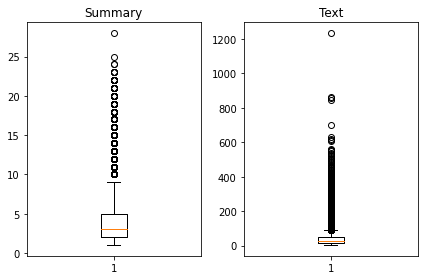

In [24]:
plt.subplot(1, 2, 1)
plt.boxplot(summary_len)
plt.title("Summary")

plt.subplot(1, 2, 2)
plt.boxplot(text_len)
plt.title("Text")

plt.tight_layout()

plt.show()

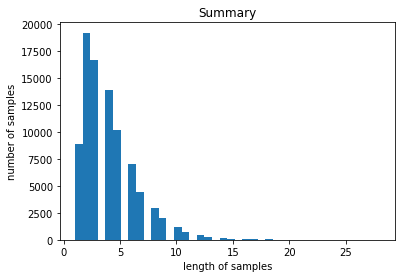

In [25]:
plt.title("Summary")
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 요약의 경우 대체적으로 15 이하의 길이를 가진다.
- 평균 길이는 4이다.

<br>

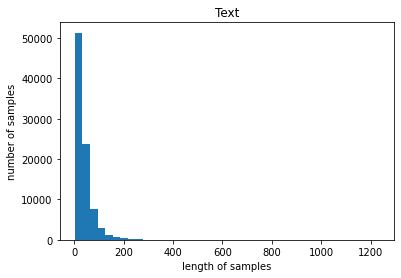

In [26]:
plt.title("Text")
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 원문 텍스트는 대체적으로 100 이하의 길이를 가진다.
- 또한 평균 길이는 38이다.

<br>

#### 2.2.4.11 패딩 길이 결정

- 여기서 패딩의 길이를 정한다.
- 평균 길이보다는 크게 잡아 각각 `Text`는 50, `Summary`는 8로 결정한다.

In [ ]:
text_max_len = 50
summary_max_len = 8

<br>

- 50과 8이라는 이 두 길이가 얼마나 많은 샘플들의 길이보다 큰 지 확인해보자.

In [ ]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if (len(s.split()) <= max_len):
            cnt = cnt + 1

    print("전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s" % (max_len, (cnt / len(nested_list))))

<br>

- 우선 `Text` 열에 대해서 확인해보자.

In [29]:
below_threshold_len(text_max_len, data['Text'])

전체 샘플 중 길이가 50 이하인 샘플의 비율 : 0.7745119121724859


- `Text` 열은 길이가 50 이하인 비율이 77%이다.
- 약 23%의 샘플이 길이 50보다 크다.

<br>

- `Summary` 열에 대해서 확인해보자.

In [30]:
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 8 이하인 샘플의 비율 : 0.9424593967517402


- `Summary` 열은 길이가 8 이하인 경우가 94%이다.

<br>

#### 2.2.4.12 패딩 길이보다 긴 데이터 제거

- 여기서는 정해준 최대 길이보다 큰 샘플들을 제거한다.

In [31]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]

print('전체 샘플 수 : ', (len(data)))

전체 샘플 수 :  65818


<br>

#### 2.2.4.13 정제 작업이 완료된 데이터 확인

In [32]:
data.head()

,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,confection around centuries light pillowy citr...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


<br>

#### 2.2.4.14 요약(`Summary`) 데이터 시작 토큰 및 종료 토큰 추가

- seq2seq 훈련을 위해서는 디코더의 예측 대상에 시작 토큰과 종료 토큰을 추가할 필요가 있다.
- 시작 토큰을 `sostoken`, 종료 토큰은 `eostoken`이라 명명하고 앞, 뒤로 추가한다.

In [33]:
# 요약 데이터에는 시작 토큰과 종료 토큰 추가
data['Summary'] = data['Summary'].apply(lambda x : "sostoken " + x + " eostoken")

data.head()

,Text,Summary
0,bought several vitality canned dog food produc...,sostoken good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,sostoken not as advertised eostoken
2,confection around centuries light pillowy citr...,sostoken delight says it all eostoken
3,looking secret ingredient robitussin believe f...,sostoken cough medicine eostoken
4,great taffy great price wide assortment yummy ...,sostoken great taffy eostoken


<br>

#### 2.2.4.15 정제 작업이 완료된 데이터 저장

In [ ]:
Text_data = list(data['Text'])
Summary_data = list(data['Summary'])

<br>

### 2.2.5 데이터의 분리

- 훈련 데이터와 테스트 데이터를 분리한다.

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Text_data, Summary_data,
                                                    test_size=0.2, random_state=0, shuffle=True)

print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :',len(y_train))
print('테스트 데이터의 개수 :',len(X_test))
print('테스트 레이블의 개수 :',len(y_test))

훈련 데이터의 개수 : 52654
훈련 레이블의 개수 : 52654
테스트 데이터의 개수 : 13164
테스트 레이블의 개수 : 13164


<br>

### 2.2.6 정수 인코딩

- 이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 한다.

<br>

#### 2.2.6.1 원문(`Text`) 데이터의 단어 집합(vocabulary) 생성

- 훈련 데이터에 대해서 단어 집합(vocabulary)을 만들어보자.
- 우선, 원문에 해당되는 `X_train`에 대해서 수행한다.

In [ ]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(X_train)

- 이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다.
- 이는 `src_tokenizer.word_index`에 저장되어져 있다.

<br>

#### 2.2.6.2 등장 빈도수가 낮은 단어 배제

- 여기서는 빈도수가 낮은 단어들은 자연어 처리에서 배제하고자 한다.
- 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는 지 확인해보자.

In [ ]:
threshold = 7

total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트

total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수 총합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():

    total_freq = total_freq + value

    if (value < threshold): # 단어의 등장 빈도수가 threshold보다 작으면
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

In [38]:
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31940
등장 빈도가 6번 이하인 희귀 단어의 수: 23707
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8233
단어 집합에서 희귀 단어의 비율: 74.22354414527238
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.3949897589412323


- 등장 빈도가 threshold` 값인 7회 미만. 즉, 6회 이하인 단어들은 단어 집합에서 무려 70% 이상을 차지한다.
- 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.39%밖에 되지 않는다.

<br>

- 여기서는 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 배제시키고자 한다.
- 위에서 이를 제외한 단어 집합의 크기를 8,233으로 계산했는데, 저자는 깔끔한 값을 선호하여 이와 비슷한 값으로 단어 집합의 크기를 8000으로 제한하겠다.

In [ ]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(X_train)

<br>

#### 2.2.6.3 원문(`Text`) 데이터 정수 시퀀스 변환

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
X_train = src_tokenizer.texts_to_sequences(X_train)
X_test = src_tokenizer.texts_to_sequences(X_test)

In [41]:
print(X_train[:5])

[[4256, 611, 816, 4477, 528, 1540, 32, 45, 4, 79, 2281, 234, 19, 1157, 2923, 948, 1122, 996, 2, 153, 10, 43], [204, 15, 154, 51, 259, 60, 73, 24, 49, 17, 886, 259, 2, 29, 209, 14, 504, 2081, 420, 13, 86, 64, 22, 2464, 134, 14, 504, 86], [112, 1570, 2, 1771, 185, 39, 505, 112, 283], [296, 105, 496, 834, 69, 103, 334, 5082, 2294, 765, 7, 908, 585, 1489, 351, 5265, 100, 75, 1908, 137, 141, 585, 864, 5083, 89, 830, 564, 1772, 305, 254, 1541, 97, 247, 2, 1600, 2100, 92, 2645], [54, 1247, 806, 5, 497, 479, 46, 236, 1218, 381, 5, 3879, 3880, 172, 479, 46, 1247]]


<br>

#### 2.2.6.4 요약(`Summary`) 데이터 단어 집합(vocabulary) 생성

In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(y_train)

- 이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다.
- 이는 `tar_tokenizer.word_index`에 저장되어져 있습니다. 

<br>

#### 2.2.6.5 등장 빈도수가 낮은 단어 배제

- 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보자.

In [ ]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

In [44]:
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10498
등장 빈도가 5번 이하인 희귀 단어의 수: 8126
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2372
단어 집합에서 희귀 단어의 비율: 77.40522004191274
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.833194065065198


- 등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 77%를 차지한다.
- 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 4.83%밖에 되지 않는다.

<br>

- 이 단어들은 정수 인코딩 과정에서 배제시키도록 한다.

In [ ]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab)
tar_tokenizer.fit_on_texts(y_train)

<br>

#### 2.2.6.6 요약(`Summary`) 데이터 정수 시퀀스 변환

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
y_train = tar_tokenizer.texts_to_sequences(y_train)
y_test = tar_tokenizer.texts_to_sequences(y_test)

In [47]:
print(y_train[:5])

[[1, 805, 2], [1, 7, 298, 138, 86, 2], [1, 25, 745, 2], [1, 488, 39, 22, 30, 12, 2], [1, 15, 16, 238, 84, 35, 12, 2]]


<br>

### 2.2.7 빈 샘플(empty samples) 제거

- 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었다는 것을 의미한다.
- 이 현상은 길이가 상대적으로 길었던 원문(`Text`)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 4밖에 되지 않았던 요약문(`Summary`)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높다.

- 요약문에서 길이가 0이 된 샘플들의 인덱스를 받아오자.
- 주의할 점은 요약문에는 `sostoken`과 `eostoken`이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플수와 동일하여 단어 집합 제한에도 삭제 되지 않는다.
- 그래서 이제 길이가 `0`이 된 요약문의 실질적 길이는 `2`이다.

In [ ]:
drop_train = [index for index, sentence in enumerate(y_train) if len(sentence) == 2]
drop_test = [index for index, sentence in enumerate(y_test) if len(sentence) == 2]

- 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 `2`인 경우의 인덱스를 각각 `drop_train`과 `drop_test`에 저장하였다.

<br>

- 삭제 전의 훈련 데이터와 테스트 데이터의 개수를 출력해보자.

In [49]:
print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :',len(y_train))
print('테스트 데이터의 개수 :',len(X_test))
print('테스트 레이블의 개수 :',len(y_test))

훈련 데이터의 개수 : 52654
훈련 레이블의 개수 : 52654
테스트 데이터의 개수 : 13164
테스트 레이블의 개수 : 13164


<br>

- 삭제 후의 개수는 다음과 같다.

In [50]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :',len(y_train))
print('테스트 데이터의 개수 :',len(X_test))
print('테스트 레이블의 개수 :',len(y_test))

훈련 데이터의 개수 : 51404
훈련 레이블의 개수 : 51404
테스트 데이터의 개수 : 12813
테스트 레이블의 개수 : 12813


<br>

### 2.2.8 패딩 하기

- 훈련 데이터와 테스트 데이터에 대해서 패딩 작업을 수행한다.
- 이미 앞서 정해둔 최대 길이를 넘는 샘플들은 제외했기 때문에 따로 길이 분포를 재확인하지는 않는다.

In [ ]:
X_train = pad_sequences(X_train, maxlen=text_max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=text_max_len, padding='post')

y_train = pad_sequences(y_train, maxlen=summary_max_len, padding='post')
y_test = pad_sequences(y_test, maxlen=summary_max_len, padding='post')

<br>

## 2.3 seq2seq + attention으로 요약 모델 설계 및 훈련

### 2.3.1 필요한 도구들 임포트

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

<br>

### 2.3.2 인코더 설계

- 인코더는 LSTM 층을 3개 쌓는다.

In [53]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

<br>

### 2.3.3 디코더 설계 (출력층 제외)

- 디코더를 설계한다.
- 단, 출력층은 제외하고 설계한다.
- 디코더의 설계는 인코더와 사실상 동일하지만 초기 상태(`initial_state`)를 인코더의 상태로 주어야 하는 것에 주의해야 한다.

In [54]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb = Embedding(tar_vocab, embedding_dim)(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

<br>

### 2.3.4 디코더의 출력층 설계

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

<br>

### 2.3.5 모델 정의

In [56]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

- 총 3,633,104개의 매개변수를 가진 seq2seq 모델이 설계된다.
- 지금까지의 모델 설계는 앞서 seq2seq 챕터에서 배웠던 내용과 동일하다.

<br>

### 2.3.6 어텐션 메커니즘이 결합된 출력층 설계

- 이번 챕터에서는 어텐션 메커니즘을 사용할 예정이다.
- 그러므로 위에서 설계한 출력층을 사용하지 않고, 어텐션 메커니즘이 결합된 새로운 출력층을 설계할 것이다.

- 어텐션 함수를 직접 작성하지 않고 이미 깃허브에 공개된 함수를 사용할 것이다.
- 아래의 코드를 통해 `attention.py` 파일을 다운로드하고, `AttentionLayer`를 임포트한다.

In [57]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/layers/attention.py", filename="attention.py")

('attention.py', <http.client.HTTPMessage at 0x7fabccedbe10>)

In [ ]:
from attention import AttentionLayer

<br>

- 어텐션 메커니즘을 이용해 디코더의 출력층을 새롭게 설계한다.

In [ ]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

<br>

### 2.3.7 어텐션 메터니즘이 결합된 출력층이 적용된 모델 정의

In [60]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

- 총 4,276,432개의 파라미터를 가진 모델이 설계된다.

<br>

### 2.3.8 모델 컴파일

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

<br>

### 2.3.9 조기 종료 조건 설정

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)

<br>

### 2.3.10 모델 학습

In [63]:
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:] \
                  ,epochs=50, callbacks=[es], batch_size = 256, validation_data=([X_test, y_test[:,:-1]], \
                  y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

Epoch 1/50
201/201 [==============================] - 122s 607ms/step - loss: 3.0272 - val_loss: 2.7397
Epoch 2/50
201/201 [==============================] - 121s 600ms/step - loss: 2.6840 - val_loss: 2.5822
Epoch 3/50
201/201 [==============================] - 119s 590ms/step - loss: 2.5255 - val_loss: 2.4382
Epoch 4/50
201/201 [==============================] - 117s 584ms/step - loss: 2.3870 - val_loss: 2.3395
Epoch 5/50
201/201 [==============================] - 117s 580ms/step - loss: 2.2882 - val_loss: 2.2802
Epoch 6/50
201/201 [==============================] - 116s 577ms/step - loss: 2.2158 - val_loss: 2.2398
Epoch 7/50
201/201 [==============================] - 116s 579ms/step - loss: 2.1556 - val_loss: 2.2009
Epoch 8/50
201/201 [==============================] - 116s 577ms/step - loss: 2.1033 - val_loss: 2.1711
Epoch 9/50
201/201 [==============================] - 115s 572ms/step - loss: 2.0556 - val_loss: 2.1496
Epoch 10/50
201/201 [==============================] - 115s 572m

<br>

### 2.3.11 손실 시각화

- 학습 과정에서 기록된 훈련 데이터의 손실과 테스트 데이터의 손실 히스토리를 시각화해보자.

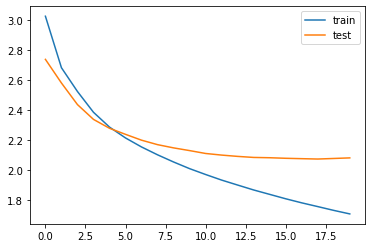

In [64]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

- 테스트 데이터의 손실이 지속적으로 줄어들다가 어느 순간부터 정체하게 된다.

<br>

## 2.4 seq2seq + attention으로 요약 모델 테스트

### 2.4.1 사전 생성

- 테스트를 위해 필요한 3개의 사전을 만든다.

In [ ]:
# 원문 단어 집합에서 정수 -> 단어를 얻음
src_index_to_word = src_tokenizer.index_word

# 요약 단어 집합에서 단어 -> 정수를 얻음
tar_word_to_index = tar_tokenizer.word_index

# 요약 단어 집합에서 정수 -> 단어를 얻음
tar_index_to_word = tar_tokenizer.index_word

<br>

### 2.4.2 테스트 단계의 seq2seq 모델 설계

- seq2seq는 훈련 단계와 테스트 단계의 동작이 다르다.
- 그러므로 테스트 단계의 모델을 별도로 다시 설계해줄 필요가 있다.
- 다시 새로운 seq2seq 모델을 만들어보자.

<br>

#### 2.4.2.1 테스트 단계의 인코더 설계

In [ ]:
encoder_model = Model(inputs=encoder_inputs,
                      outputs=[encoder_outputs, state_h, state_c])

<br>

#### 2.4.2.2 테스트 단계의 디코더 설계

In [67]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size, ))
decoder_state_input_c = Input(shape=(hidden_size, ))

dec_emb2 = dec_emb_layer(decoder_inputs) # TODO: dec_emb_layer 수정 필요

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용.
# 이는 뒤의 함수 decode_sequence()에 구현

# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2,
                                                    initial_state=[decoder_state_input_h,
                                                                   decoder_state_input_c])

NameError: ignored

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))

attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input,
                                            decoder_outputs2])

decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2,
                                                          attn_out_inf])

# 디코더의 출력층
deocder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                                          decoder_state_input_h,
                                          decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2]])

- 테스트 단계를 위한 모델이 완성되었다.

<br>

### 2.4.3 테스트를 위한 함수 설계

- 테스트를 위해 사용되는 함수 `decode_sequence`를 설계한다.

In [ ]:
def decode_sequence(input_seq):

    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, tar_vocab_size)) # TODO: tar_vocab_size 수정 필요
    target_seq[0, 0, tar_to_index['\t']] = 1. # TODO: tar_to_index 수정 필요, \t -> sostoken으로 수정 필요

    stop_condition = False
    decoded_sentence = ""

    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        # 이전 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index] # index_to_tar 수정 필요
        decoded_sentence += sampled_char

        # <EOS>에 도달하거나 최대 길이를 넘으면 중단
        if (sampled_char == '\n' or len(decoded_sentence) > max_tar_len): # \n -> eostoken 수정 필요, max_tar_len 수정 필요
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1, 1, tar_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 상태 없데이트
        states_value = [h, c]

    return decoded_sentence

<br>

### 2.4.4 정수 시퀀스를 텍스트 시퀀스로 만드는 함수 설계

- 테스트 단계에서 원문과 실제 요약문, 예측 요약문을 비교하기 위해 정수 시퀀스를 텍스트 시퀀스로 만드는 함수를 설계한다.

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp = ''
    for i in input_seq:
        if (i != 0):
            temp = temp + src_index_to_word[i] + ' '
    return temp

In [ ]:
# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if ( (i != 0 and 1 != target_word_index['sostoken']) and i != target_word_index['eostoken'] ):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

<br>

### 2.4.5 테스트 샘플 중 500번부터 1000번까지 테스트 실시

In [ ]:
for i in range(500, 1000):
    print('원문 : ', seq2text(X_test[i]))
    print('실제 요약문 : ', seq2summary(y_test[i]))
    print('예측 요약문 : ', decode_sequence(X_test[i].reshape(1, text_max_len)))
    print('\n')

- 실제 요약문과 완전히 똑같지 않으면서 원문의 맥락을 잘 잡아서 예측된 요약문들이 존재하는 것을 확인할 수 있다.